In [ ]:
!pip install neuron

In [ ]:
!nrnivmodl mechanisms

In [1]:
from neuron import h
from neuron import gui
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt

In [2]:
h.load_file('load_L5PC_Hu2009.hoc')

h.topology()

	1 

|----------|       soma(0-1)
            `---------|       hill(0-1)
                       `---------|       ais[0](0-1)
                                  `---------|       ais[1](0-1)
                                             `---------|       ais[2](0-1)
                                                        `---------|       ais[3](0-1)
                                                                   `---------|       ais[4](0-1)
                                                                              `---------|       ais[5](0-1)
                                                                                         `---------|       ais[6](0-1)
                                                                                                    `---------|       ais[7](0-1)
                                                                                                               `---------|       ais[8](0-1)
                                                     

1.0

All sections are now defined in HOC, so to access, we have to use `h.<section name>`. Or to make accessing things from python easier you can save the hoc section to a python variable

In [3]:
soma = h.soma
print(type(soma)) # python neuron section, can use python methods on hoc section
soma.psection()['density_mechs'].keys() # look at channels inserted into soma

<class 'nrn.Section'>


dict_keys(['pas', 'ca', 'cad', 'kca', 'km', 'kv', 'na12', 'na16'])

Note: For whatever reason, Hu used both 'na' and 'na12' which are identical mod files and are both meant to represent Nav1.2. I replaced na in their code to na12 to make thing clearer. Their na is also different from the na.mod used in Mainen, so this allows you to use na.mod for the Mainen model and na12.mod for the Hu 2009 version of the Mainen model. Also, these mod files use $pS/\mu m^{2}$, while the `Nav11.mod` and `ichanWT2005.mod` use $S/cm^{2}$ ($1 \; S/cm^2 = 10,000 \; pS/\mu m^2$). 

Another note, this model has multiple sections defining the axon hillock and axon initial segment (AIS). It looks like changing somatic Nav (even without adding Nav1.1) doesn't seem to affect AP threshold or firing rate much. Hu 2009 paper shows this to some extent in Fig. 5D. This may be because the axon hillock and AIS have such high Nav channel density in this model (the exact density of Nav channels in the AIS is still debated). So, in addition to testing the effect of varyign Nav1.1 in the soma alone, you may want to vary nav1.1 in both the soma and axon hillock together. There's actually some evidence nav1.1 is expressed in the AIS of some cortical neurons (https://www.jneurosci.org/content/28/53/14329.short)

In [4]:
print(soma.gbar_na12)
print(soma.gbar_na16) # this is set to zero (idk why they inserted this all...)

total_soma_gna = soma.gbar_na12 # pS/um^2

# Axon hillock 
hill = h.hill # name of axon hillock section
total_hill_gna = hill.gbar_na12

# Add IClamp
iclamp = h.IClamp(soma(0.5))
iclamp.delay = 5
iclamp.dur = 1000
iclamp.amp = 1

t_vec = h.Vector().record(h._ref_t)
soma_v = h.Vector().record(soma(0.5)._ref_v)

80.0
0.0


Try adding Nav1.1 and setting conductance ratio.

In [5]:
soma.insert('nav11')
hill.insert('nav11')

def set_soma_hill_nav11(nav11_ratio,total_soma_gna,total_hill_gna):
    soma.gbar_nav11 = nav11_ratio*total_soma_gna*1e-4 # convert to S/cm2
    soma.gbar_na12 = (1-nav11_ratio)*total_soma_gna # pS/um^2
    hill.gbar_nav11 = nav11_ratio*total_hill_gna*1e-4 # convert to S/cm2
    hill.gbar_na12 = (1-nav11_ratio)*total_hill_gna # pS/um^2

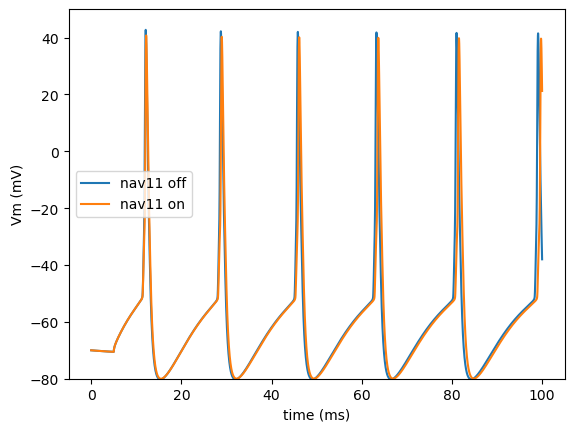

In [7]:
nav11_ratio = 0 # set ratio (0-1) of nav1.1 to nav1.2 density
# Try using nav1.1 in soma/axon hillock
set_soma_hill_nav11(nav11_ratio,total_soma_gna,total_hill_gna)

# Set simulation parameters and run
h.celsius = 37
h.tstop = 100
h.run()
soma_v_nav11_off = np.array(soma_v) # save somatic voltage recording

# Turn on Nav1.1 exclusively
nav11_ratio = 1
set_soma_hill_nav11(nav11_ratio,total_soma_gna,total_hill_gna)
h.run()
soma_v_nav11_on = np.array(soma_v) # save somatic voltage recording

# Plot 

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t_vec,soma_v_nav11_off,label='nav11 off')
ax.plot(t_vec,soma_v_nav11_on,label='nav11 on')
ax.set_xlabel('time (ms)')
ax.set_ylabel('Vm (mV)');
ax.set_ylim(-80,50)
ax.legend();
# Reset to normal
set_soma_hill_nav11(0,total_soma_gna,total_hill_gna)
